# Separating A Capella Songs into their Separated Vocal Tracks

One A Capella song is usually made up by 5-8 singers singing their respective parts together to form mainly the **lead_vocal, soprano, alto, bass, tenor, and vocal percussion.** <br>

In this notebook, we aim to **train our own Machine Learning Model** to **separate these 6 main tracks** from one another, given an A Capella song audio input. We will be using a dataset with Japanese A Capella songs (Ja Capella).

In [22]:
import glob
import math
import zipfile
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
import IPython.display as ipd
import soundfile as sf  # for saving the WAV file

from glob import glob

In [ ]:
# Please ensure to have downloaded Ja Capella dataset and followed instructions from README.md before continuing

with zipfile.ZipFile("Dataset/Jacapella.zip", 'r') as zip_ref:
        zip_ref.extractall("Dataset/Jacapella")

In [23]:
df = pd.read_csv('Dataset/Jacapella/meta.csv')

In [24]:
df.sample(5)

,title_in_en,title_in_ja,lyric_writer,copyright_of_lyric_writer,composer,copyright_of_composer,arranger_in_en,arranger_in_ja,subset,voice_part,singer_id,gender,first_lang
182,katatsumuri,かたつむり,作詞者不詳（文部省唱歌）,PD,作曲者不詳（文部省唱歌）,PD,Kana Yokoi,横井香菜,neutral,alto,A3,female,ja
196,hato,鳩,作詞者不詳（文部省唱歌）,PD,作曲者不詳（文部省唱歌）,PD,Mika Sato,佐藤美香,neutral,bass,Bs1,male,ja
193,hato,鳩,作詞者不詳（文部省唱歌）,PD,作曲者不詳（文部省唱歌）,PD,Mika Sato,佐藤美香,neutral,soprano,S4,female,ja
89,touriyanse,通りゃんせ,わらべうた,PD,わらべうた,PD,Antares,あんたれす,bossa_nova,vocal_percussion,VP3,male,ja
207,momotarou,桃太郎,作詞者不詳（文部省唱歌）,PD,岡野貞一,PD,Mika Sato,佐藤美香,neutral,tenor,T4,male,ja


In [25]:
# create df_mix to show all the combines audio of mixed voice parts for each song
# append their file directory into the df_mix as well

titles = []
subset = []
file_dir = []
voice_part = []
for index in df.index:
    if df.iloc[index,0] not in titles:
        titles.append(df.iloc[index,0])
        subset.append(df.iloc[index,8])
        voice_part.append("mixture")
        file_dir.append(f"Dataset/Jacapella/{df.iloc[index,8]}/{df.iloc[index,0]}/mixture.wav")
        
df_mix = pd.DataFrame([], columns=['title_in_en', 'subset','voice_part','audio_file_dir'])
df_mix['title_in_en'] = titles
df_mix['subset'] = subset
df_mix['voice_part'] = voice_part
df_mix['audio_file_dir'] = file_dir

In [26]:
# Appending file directory of each vocal track
audio_file_dir = []
for index in df.index:
    title = df.iloc[index,0]
    subset = df.iloc[index,8]
    voice = df.iloc[index,9]
    audio_file_dir.append("Dataset/Jacapella/" + str(subset) + "/" + str(title) + "/" + str(voice) + ".wav")

# Added new column in df_audio to show each audio track's directory
df["audio_file_dir"] = audio_file_dir


In [27]:
# creating separate df for each vocal parts

df_leadvocal = pd.DataFrame()
df_soprano = pd.DataFrame()
df_alto = pd.DataFrame()
df_tenor = pd.DataFrame()
df_bass = pd.DataFrame()
df_percussion = pd.DataFrame()

for index,value in df.iterrows():
    if df.iloc[index, 9] == "lead_vocal":
        df_leadvocal = df_leadvocal.append(value, ignore_index = True)
    elif df.iloc[index, 9] == "soprano":
        df_soprano = df_soprano.append(value, ignore_index = True)
    elif df.iloc[index, 9] == "alto":
        df_alto = df_alto.append(value, ignore_index = True)
    elif df.iloc[index, 9] == "tenor":
        df_tenor = df_tenor.append(value, ignore_index = True)
    elif df.iloc[index, 9] == "bass":
        df_bass = df_bass.append(value, ignore_index = True)
    else:
        df_percussion= df_percussion.append(value, ignore_index = True)

In [28]:
df_leadvocal.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_soprano.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_alto.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_tenor.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_bass.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)
df_percussion.drop(columns = ["title_in_ja", "lyric_writer", "copyright_of_lyric_writer", "composer", "copyright_of_composer", "arranger_in_en", "arranger_in_ja", "singer_id", "gender", "first_lang"], axis=1, inplace = True)


**Amplitude Change for each vocal part**

The graph displays the time on the horizontal (X) axis and the amplitude on the vertical (Y) axis but it doesn’t tell us what’s happening to frequencies.

In [29]:
# Add audio time series for each audio track

def add_time_series(df):
    
    # audio time series describes the amplitude of the audio at different timesteps.
    audio_time_series = []

    # sampling rate, sr
    sampling_rate = []

    for index, data in df.iterrows():
        y, sr = librosa.load(data['audio_file_dir'], sr = 11025, duration = 60)
        audio_time_series.append(y)
        sampling_rate.append(sr)

    df["audio_time_series"] = audio_time_series
    df['sampling_rate'] = sampling_rate
    return df

In [30]:
dfs = [df_leadvocal, df_soprano, df_alto, df_tenor, df_bass, df_percussion, df_mix]

In [31]:
for df in dfs:
    add_time_series(df)

# Feature Engineering

**4. Short-Term Fourier Transform (STFT)** <br>

Its complex-valued coefficients provide the frequency and phase content of local sections of a signal as it evolves over time.

In [32]:
def stft(df):
    stft = []
    mag_stft = []
    phase_stft = []
    for index, data in df.iterrows():
        
        # Return the complex Short Term Fourier Transform
        y = data['audio_time_series']
        stft_temp = librosa.stft(y, n_fft=512)

        stft.append(librosa.stft(y))
        mag = np.abs(librosa.stft(y))
        mag_stft.append(mag)
        phase = np.angle(librosa.stft(y))
        phase_stft.append(phase)
                                       
    df['stft'] = stft
    df['mag_stft'] = mag_stft

    df['phase_stft'] = phase_stft

    return df

In [33]:
for df in dfs:
    stft(df)

In [34]:
# checkpoint
# df_leadvocal.to_pickle('df_leadvocal.pkl')
# df_soprano.to_pickle('df_soprano.pkl')
# df_alto.to_pickle('df_alto.pkl')
# df_tenor.to_pickle('df_tenor.pkl')
# df_bass.to_pickle('df_bass.pkl')
# df_percussion.to_pickle('df_percussion.pkl')
# df_mix.to_pickle('df_mix.pkl')

# df_leadvocal = pd.read_pickle('df_leadvocal.pkl')
# df_soprano = pd.read_pickle('df_soprano.pkl')
# df_alto = pd.read_pickle('df_alto.pkl')
# df_tenor = pd.read_pickle('df_tenor.pkl')
# df_bass = pd.read_pickle('df_bass.pkl')
# df_percussion = pd.read_pickle('df_percussion.pkl')
# df_mix = pd.read_pickle('df_mix.pkl')

df_all = pd.concat([df_leadvocal, df_soprano, df_alto, df_tenor, df_bass, df_percussion, df_mix], axis=0, ignore_index = True)

In [35]:
dfs = [df_leadvocal, df_soprano, df_alto, df_tenor, df_bass, df_percussion, df_mix]
df1 = df_mix[['title_in_en', 'mag_stft', 'phase_stft','stft']].rename(columns={'stft':'stft_mix'})
dfs = dfs[:-1]

for df2 in dfs:
    voice_part = df2['voice_part'].iloc[0]
    print(voice_part)
    df2 = df2[['title_in_en', 'stft']]
    df1 = df1.merge(df2, how='outer', on='title_in_en',suffixes = ('', '_' + voice_part))
df1.rename(columns={"mag_stft": "mag_stft_mix", "phase_stft": "phase_stft_mix", "stft":"stft_lead_vocal"}, inplace=True)
df = df1

lead_vocal
soprano
alto
tenor
bass
vocal_percussion


In [36]:
df.columns

Index(['title_in_en', 'mag_stft_mix', 'phase_stft_mix', 'stft_mix',
       'stft_lead_vocal', 'stft_soprano', 'stft_alto', 'stft_tenor',
       'stft_bass', 'stft_vocal_percussion'],
      dtype='object')

In [37]:
# NMF

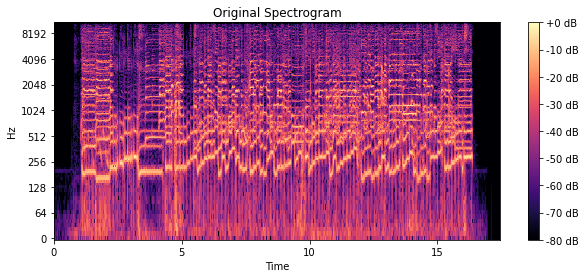

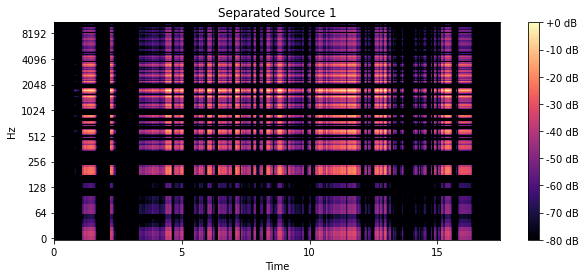

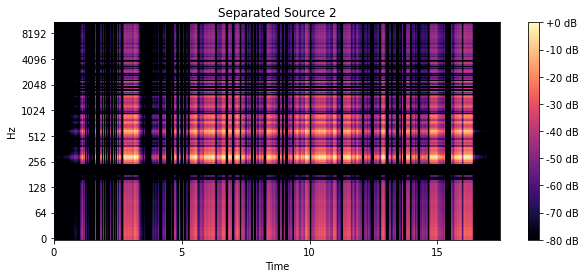

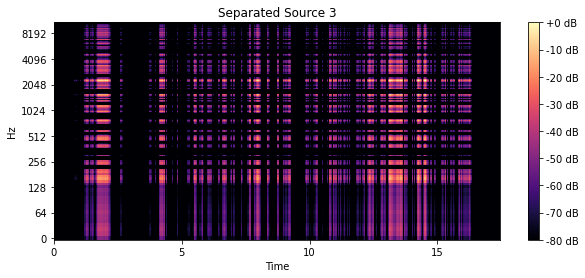

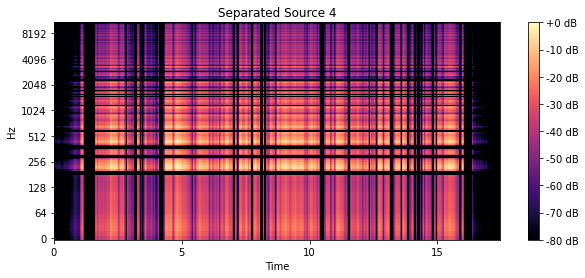

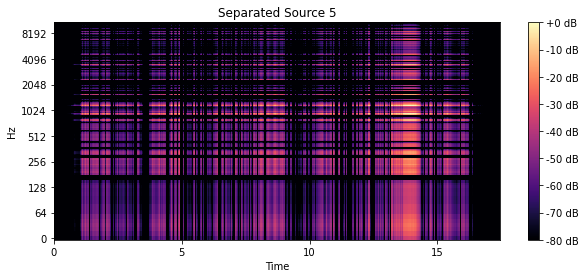

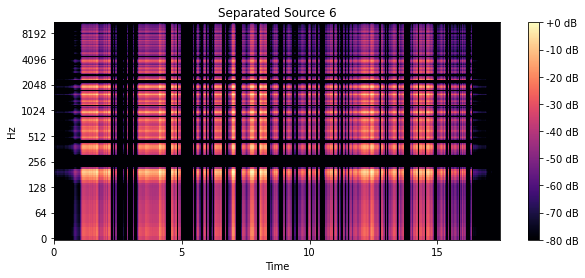

In [38]:
# For visualising
from sklearn.decomposition import NMF

def load_and_preprocess_audio(file_path, sr=22050):
    y, _ = librosa.load(file_path, sr=sr)
    D = librosa.stft(y)
    return y, D

def plot_spectrogram(D, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max), y_axis='log', x_axis='time')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def perform_nmf(source_count, D):
    model = NMF(n_components=source_count, init='random', random_state=0)
    W = model.fit_transform(np.abs(D))
    H = model.components_

    source_spectrograms = [W[:, i:i+1] @ H[i:i+1, :] for i in range(source_count)]
    return source_spectrograms

def reconstruct_sources(spectrograms, y_phase):
    sources = [librosa.istft(np.multiply(spectrogram, np.exp(1j * np.angle(y_phase)))) for spectrogram in spectrograms]
    return sources

# visualising output
stft = df["stft_mix"][0]

plot_spectrogram(stft, 'Original Spectrogram')

source_spectrograms = perform_nmf(6,stft)

for i, source_spectrogram in enumerate(source_spectrograms):
    plot_spectrogram(source_spectrogram, f'Separated Source {i + 1}')

reconstructed_sources = reconstruct_sources(source_spectrograms, np.angle(stft))

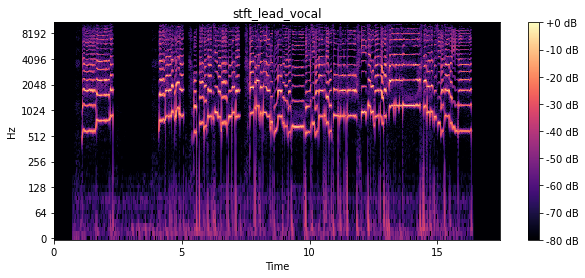

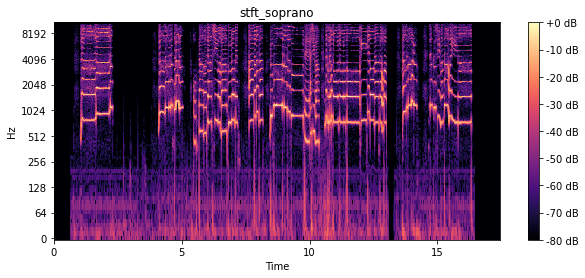

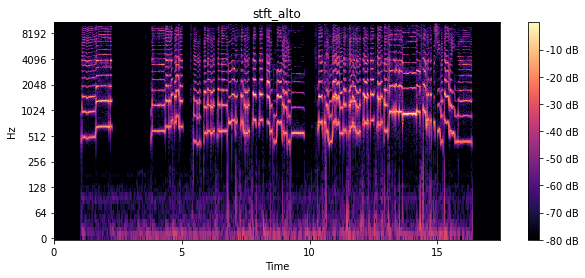

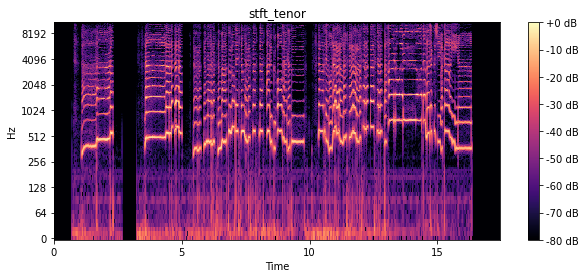

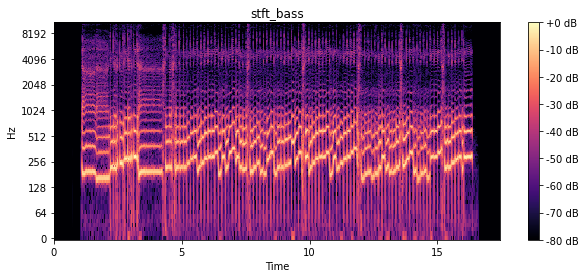

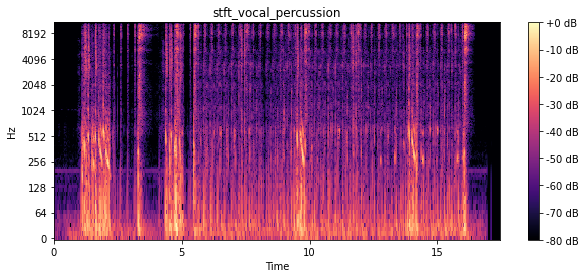

In [50]:
# Comparing with original spectrogram
ground_truth_cols = ['stft_lead_vocal', 'stft_soprano', 'stft_alto', 'stft_tenor',
       'stft_bass', 'stft_vocal_percussion']
for i in ground_truth_cols:
    plot_spectrogram(df[i][0], i)

In [39]:
# For comparing
from sklearn.decomposition import NMF

def perform_nmf(source_count, D):
    model = NMF(n_components=source_count, init='random', random_state=0)
    W = model.fit_transform(np.abs(D))
    H = model.components_

    source_spectrograms = [W[:, i:i+1] @ H[i:i+1, :] for i in range(source_count)]
    return source_spectrograms

def reconstruct_sources(spectrograms, y_phase):
#     sources = [librosa.istft(np.multiply(spectrogram, np.exp(1j * np.angle(y_phase)))) for spectrogram in spectrograms]
#     print('np.exp(1j * np.angle(y_phase):', np.exp(1j * np.angle(y_phase)).shape)
#     print('spectrograms: ', spectrograms[0].shape)
#     print('np.multiply(spectrogram, np.exp(1j * np.angle(y_phase))): ', np.multiply(spectrograms[0], np.exp(1j * np.angle(y_phase))).shape)
    sources = [librosa.istft(np.multiply(spectrogram, np.exp(1j * np.angle(y_phase))) , length=spectrograms[0].shape[0] * spectrograms[0].shape[1]).reshape(spectrograms[0].shape) for spectrogram in spectrograms]

    return sources

def process_audio(row):
    stft_mix = row['stft_mix']
    source_count = 6 
    # Perform NMF on the mixture
    source_spectrograms = perform_nmf(source_count, stft_mix)
    
    # Reconstruct sources from the spectrograms
    reconstructed_sources = reconstruct_sources(source_spectrograms, stft_mix)
    
    # Add new columns for each separated source to the DataFrame
    for i, source in enumerate(reconstructed_sources):
        row[f'separated_source_{i+1}'] = source
    
    return row

# Apply the processing function to each row in the DataFrame
df = df.apply(process_audio, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [40]:
df.head()

,title_in_en,mag_stft_mix,phase_stft_mix,stft_mix,stft_lead_vocal,stft_soprano,stft_alto,stft_tenor,stft_bass,stft_vocal_percussion,separated_source_1,separated_source_2,separated_source_3,separated_source_4,separated_source_5,separated_source_6
0,otamajakushi,"[[0.24747078, 0.170763, 0.09177366, 0.21410973...","[[0.0, 0.0, 0.0, 0.0, 0.0, 3.1415927, 3.141592...","[[(0.24747078+0j), (0.170763+0j), (0.09177366+...","[[0j, 0j, 0j, 0j, (2.2838604e-15+0j), (-3.3872...","[[0j, 0j, 0j, 0j, (2.2838604e-15+0j), (-3.3872...","[[(0.0056893546+0j), (0.0003187706+0j), (-0.00...","[[0j, 0j, 0j, 0j, (2.2838604e-15+0j), (-3.3872...","[[0j, 0j, 0j, 0j, (2.2838604e-15+0j), (-3.3872...","[[(0.21681367+0j), (0.15094775+0j), (0.0815946...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.297635e-06, 0.00012224655, 3.9698272e-05, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-3.167488e-05, 0.0005248786, 0.00036020187, ...","[[1.600706e-05, 7.8770216e-05, 6.176355e-05, 6...","[[0.00017322888, 0.0007030974, 0.00056310516, ..."
1,popura,"[[0.007490636, 0.0023916946, 0.00023868978, 0....","[[3.1415927, 3.1415927, 0.0, 3.1415927, 3.1415...","[[(-0.007490636+0j), (-0.0023916946+0j), (0.00...","[[(-3.0320916e-05+0j), (-5.5078588e-05+0j), (-...","[[(-0.048754215+0j), (-0.022335762+0j), (0.001...","[[(0.038889147+0j), (0.020914609+0j), (1.32823...","[[(-3.0320916e-05+0j), (-5.5078588e-05+0j), (-...","[[(-3.0320916e-05+0j), (-5.5078588e-05+0j), (-...","[[(-3.0320916e-05+0j), (-5.5078588e-05+0j), (-...","[[8.826859e-06, 4.0381346e-06, -5.681067e-06, ...","[[1.8213528e-06, 2.9020719e-06, 1.9642196e-07,...","[[3.0273979e-05, 3.1746687e-05, 1.0954382e-05,...","[[6.8126574e-06, 3.6771553e-06, -8.943202e-06,...","[[6.7012575e-06, 9.2644295e-06, 6.6215116e-06,...","[[2.2162706e-07, -1.896419e-07, -6.55152e-07, ..."
2,nanatsunoko,"[[0.005014461, 0.002578657, 1.5473834e-06, 1.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[(0.005014461+0j), (0.002578657+0j), (1.54738...","[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...","[[(0.0017348685+0j), (0.00087629404+0j), (6.51...","[[(0.0072955233+0j), (0.0037629288+0j), (2.584...","[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...","[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...","[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...","[[3.2022526e-05, 6.3000785e-05, 4.6969086e-05,...","[[1.8221031e-05, 6.9295944e-05, 5.2209885e-05,...","[[2.102126e-05, 6.036675e-05, 4.866129e-05, 5....","[[2.7390644e-05, 5.204859e-05, 3.8146776e-05, ...","[[2.9474333e-05, 5.3171403e-05, 4.2066185e-05,...","[[1.1685734e-06, 3.1491224e-06, 2.4452709e-06,..."
3,akaikutsu,"[[4.1203017e-05, 2.0601852e-05, 7.31485e-13, 3...","[[3.1415927, 3.1415927, 0.0, 3.1415927, 0.0, 0...","[[(-4.1203017e-05+0j), (-2.0601852e-05+0j), (7...","[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...","[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...","[[(-0.00011165179+0j), (-5.5826822e-05+0j), (1...","[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...","[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...","[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...","[[-8.077761e-07, -5.321286e-07, -3.063911e-07,...","[[-3.3354088e-06, -1.9766292e-06, -1.0515631e-...","[[-1.0139235e-06, -6.9881327e-07, -5.1241324e-...","[[-7.885161e-06, -4.387514e-06, -1.8113577e-06...","[[-8.310033e-07, -5.279957e-07, -1.6811968e-07...","[[-1.7985534e-06, -1.1648102e-06, -8.801725e-0..."
4,machibouke,"[[0.11218791, 0.08130142, 0.005173045, 0.00030...","[[0.0, 0.0, 0.0, 3.1415927, 3.1415927, 3.14159...","[[(0.11218791+0j), (0.08130142+0j), (0.0051730...","[[(-3.0320916e-05+0j), (-5.5078588e-05+0j), (-...","[[(-3.0320916e-05+0j), (-5.5078588e-05+0j), (-...","[[(-0.0040416857+0j), (-0.0021076316+0j), (-6....","[[(0.20905258+0j), (0.15101433+0j), (0.0097519...","[[(-0.005444919+0j), (-0.003914362+0j), (-0.00...","[[(-3.0320916e-05+0j), (-5.5078588e-05+0j), (-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-9.68207e-06, 0.00016777965, 5.941514e-05, 0..."

In [46]:
import mir_eval
from mir_eval.separation import bss_eval_sources
def evaluate_row(i):
    
    sep_source_cols = ['separated_source_1', 'separated_source_2','separated_source_3','separated_source_4','separated_source_5','separated_source_6']

    sep_sources = np.array([df[col][i] for col in sep_source_cols])

    # List of column names for separated sources
    ground_truth_sources_cols = ['stft_lead_vocal', 'stft_soprano', 'stft_alto', 'stft_tenor', 'stft_bass', 'stft_vocal_percussion']

    # Ground truth sources
    ground_truth_sources = np.array([df[col][i] for col in ground_truth_sources_cols])

#     print(sep_sources.shape)
#     print(sep_sources.dtype)
#     print(ground_truth_sources.shape)

#     print(ground_truth_sources.dtype)
    arr_shape = sep_sources[0].shape
    # Initialize lists to store matching results
    matching_results = []
    try:
        sdr, sir, sar, perm = bss_eval_sources(ground_truth_sources.reshape(6,arr_shape[0] *arr_shape[1]).astype(np.float32), sep_sources.reshape(6,arr_shape[0] *arr_shape[1]))
        # Store the matching results
        matching_results_df = pd.DataFrame({'SDR': sdr, 'SIR': sir, 'SAR': sar, 'PERM': perm})
        matching_results_df['sep_source_cols'] = sep_source_cols
        matching_results_df = matching_results_df.set_index('sep_source_cols')
        matching_results_df['matching_voice_part'] = matching_results_df['PERM'].apply(lambda x : ground_truth_sources_cols[x])
        # Print or analyze the matching results
        print(matching_results_df)
        return sdr, sir, sar
    except Exception as e:
        print(e)
        return None,None, None


In [47]:
sdr_list, sir_list, sar_list = [], [] , []
sdr_list, sir_list, sar_list = [], [],[]
for i in range(len(df)):
    sdr, sir, sar = evaluate_row(i) #this takes really long cause the array is very large
    sdr_list.append(sdr)
    sir_list.append(sir)
    sar_list.append(sar)


C:\Users\Kruiseq\AppData\Local\Temp/ipykernel_21632/669273169.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  sdr, sir, sar, perm = bss_eval_sources(ground_truth_sources.reshape(6,arr_shape[0] *arr_shape[1]).astype(np.float32), sep_sources.reshape(6,arr_shape[0] *arr_shape[1]))


                          SDR       SIR        SAR  PERM  \
sep_source_cols                                            
separated_source_1 -29.278273 -2.266985 -24.979560     1   
separated_source_2 -26.831724 -4.714592 -20.826765     3   
separated_source_3 -26.958672 -2.655676 -22.404475     0   
separated_source_4 -25.853657 -2.982909 -21.078204     5   
separated_source_5 -25.615434 -3.905727 -20.197854     2   
separated_source_6 -37.021369 -7.872738 -28.486792     4   

                      matching_voice_part  
sep_source_cols                            
separated_source_1           stft_soprano  
separated_source_2             stft_tenor  
separated_source_3        stft_lead_vocal  
separated_source_4  stft_vocal_percussion  
separated_source_5              stft_alto  
separated_source_6              stft_bass  


C:\Users\Kruiseq\AppData\Local\Temp/ipykernel_21632/669273169.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  sdr, sir, sar, perm = bss_eval_sources(ground_truth_sources.reshape(6,arr_shape[0] *arr_shape[1]).astype(np.float32), sep_sources.reshape(6,arr_shape[0] *arr_shape[1]))


                          SDR       SIR        SAR  PERM  \
sep_source_cols                                            
separated_source_1 -28.267342 -2.418665 -23.870156     1   
separated_source_2 -28.474055 -0.275705 -25.317134     0   
separated_source_3 -26.941113 -5.610791 -20.244019     4   
separated_source_4 -29.625038 -6.486489 -22.237580     2   
separated_source_5 -27.559824 -3.007496 -22.775229     3   
separated_source_6 -28.167325 -2.192977 -23.912576     5   

                      matching_voice_part  
sep_source_cols                            
separated_source_1           stft_soprano  
separated_source_2        stft_lead_vocal  
separated_source_3              stft_bass  
separated_source_4              stft_alto  
separated_source_5             stft_tenor  
separated_source_6  stft_vocal_percussion  


C:\Users\Kruiseq\AppData\Local\Temp/ipykernel_21632/669273169.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  sdr, sir, sar, perm = bss_eval_sources(ground_truth_sources.reshape(6,arr_shape[0] *arr_shape[1]).astype(np.float32), sep_sources.reshape(6,arr_shape[0] *arr_shape[1]))


KeyboardInterrupt: 

In [48]:
for index, a_list in enumerate([sdr_list, sir_list, sar_list]):
    list_name = ['sdr_list', 'sir_list', 'sar_list']
    best_result_list = []
    for a_ele in a_list:
        #first number is best PERM
        if a_ele is not None:
            best_result_list.append(a_ele[0])
    arr = np.array(best_result_list)
    print(f'{list_name[index]}: {arr.mean()}')

sdr_list: -28.772807883695236
sir_list: -2.342824946047407
sar_list: -24.424858471429832


In [ ]:
# visualing output

In [ ]:
# output wav file, only do if u sure prev steps r ok

In [51]:
def stft_to_wav(sr, stft, output_wav_path):
    # Reconstruct the audio signal from the STFT
    y_reconstructed = librosa.istft(stft)

    # Save the reconstructed audio as a new WAV file
    sf.write(output_wav_path, y_reconstructed, sr)

In [64]:
import os

sep_source_cols = ['separated_source_1', 'separated_source_2','separated_source_3','separated_source_4','separated_source_5','separated_source_6']
# output all songs
# for index, row in df.iterrows():
#     for a_col in sep_source_cols:
#         stft_to_wav(11025, row[a_col], f'{row["title_in_en"]}/{a_col}.wav')

# output only the first row
for a_col in sep_source_cols:
    directory = f'Output/{df.iloc[0]["title_in_en"]}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    stft_to_wav(11025, df.iloc[0][a_col], f'{directory}/{a_col}.wav')